In [2]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import snscrape.modules.twitter as sntwitter
import preprocessor as p
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


## Params

In [4]:
tweets_dir = os.path.join('./data/tweets')
max_results = 1000

In [6]:
# Obtain company metadata
company_meta = pd.read_csv('./data/ipo_data_cleaned.csv', index_col=0)
company_meta.head()

,IPO Date,Symbol,Name,IPO Price,IPO Open Price,Shares Outstanding,IPO Market Capitalization,Volume Traded on Opening Day,No. of Employees,Currency,CPI Seasonally Adj,IPO + 1wk,Close Price,Price Change,Price Change 2,Price Up?,diff_exp
0,"Jan 4, 2019",SXTC,China SXT Pharmaceuticals,4.0,17.96,5937500.0,1.066375e+08,10372.0,105.0,USD,252.493,2019-01-11,24.8000,6.8400,1.380846,1,13.96
1,"Jan 8, 2019",MTC,MMTec,4.0,4.50,19800000.0,8.910000e+07,179950.0,33.0,USD,252.493,2019-01-15,7.4800,2.9800,1.662222,1,0.50
2,"Jan 8, 2019",MDJH,MDJM Ltd.,5.0,4.75,11980000.0,5.690500e+07,34720.0,145.0,USD,252.493,2019-01-15,3.8895,-0.8605,0.818842,0,0.25
3,"Jan 9, 2019",BCOW,1895 Bancorp of Wisconsin,10.0,10.50,3200450.0,3.360472e+07,212436.0,124.0,USD,252.493,2019-01-16,10.0000,-0.5000,0.952381,0,0.50
4,"Jan 17, 2019",RBKB,Rhinebeck Bancorp,10.0,11.31,4162883.0,4.708221e+07,823975.0,166.0,USD,252.493,2019-01-24,11.5800,0.2700,1.023873,1,1.31


In [7]:
pbar = tqdm(total=company_meta.shape[0])

tweets_per_company = []
try:
    for ipo_date, ticker, company in company_meta[[
        'IPO Date',
        'Symbol',
        'Name',
    ]].values:
        pbar.set_description(f"Cumulative Tweets: {sum(tweets_per_company)}; Company: {company}")
        out_csv = os.path.join(tweets_dir, str(ticker)+'.csv')

        # caching
        if os.path.isfile(out_csv):
            tweets_per_company.append(pd.read_csv(out_csv).shape[0])
            pbar.update(1)
            continue

        # date stuff
        ipo_date = pd.to_datetime(ipo_date).date()
        week_before = ipo_date - pd.to_timedelta(14, unit='d')

        # get tweets
        tweets_list = []
        for i, tweet in enumerate(sntwitter.TwitterSearchScraper(f'{company} OR {ticker} since:{week_before} until:{ipo_date} lang:en').get_items()):
            if i >= max_results:
                break

            tweets_list.append([
                tweet.date, 
                p.clean(tweet.content), 
                tweet.replyCount,
                tweet.retweetCount,
                tweet.likeCount,
                tweet.quoteCount,
                ])

        tweets_df = pd.DataFrame(tweets_list, columns=[
            'date', 
            'content', 
            'replyCount', 
            'retweetCount', 
            'likeCount',
            'quoteCount',
        ])

        tweets_df['date'] = pd.to_datetime(tweets_df['date']).dt.date
        tweets_df.to_csv(out_csv)
        tweets_per_company.append(tweets_df.shape[0])
        pbar.update(1)

except KeyboardInterrupt:
    print('Interrupted')
    pass

pbar.close()

Cumulative Tweets: 220830; Company: Orion Office REIT: 100%|██████████| 1050/1050 [16:55<00:00,  1.03it/s] 


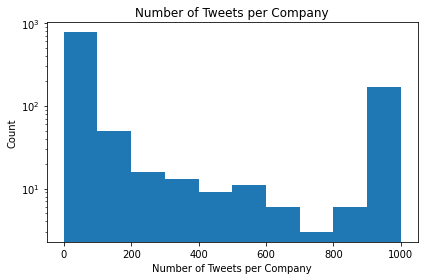

In [8]:
import matplotlib.pyplot as plt
plt.hist(tweets_per_company)
plt.title('Number of Tweets per Company')
plt.ylabel('Count')
plt.xlabel('Number of Tweets per Company')
plt.yscale('log')
plt.tight_layout()
plt.savefig('graphs/tweetcounts.jpg')
plt.show()

In [9]:
def get_sentiment(sentence):
    sentence = str(sentence)
    try:
        sentiment = analyzer.polarity_scores(str(sentence)['compound'])
    except:
        sentiment =  -100

    return sentiment

In [10]:
# Sentiment analysis
pbar = tqdm(total=company_meta.shape[0])
analyzer = SentimentIntensityAnalyzer()

sentiments = []
try:
    for ipo_date, ticker, company in company_meta[[
        'IPO Date',
        'Symbol',
        'Name',
    ]].values:
        # pbar.set_description(f"Company: {company}")
        out_csv = os.path.join(tweets_dir, str(ticker)+'.csv')

        tweets_df = pd.read_csv(out_csv, index_col=0)

        # caching
        if 'sentiment' in tweets_df.columns:
            sentiments.extend(tweets_df['sentiment'].values)
            pbar.update(1)
            continue

        # main
        tweets_df['sentiment'] = tweets_df['content'].apply(lambda sentence: analyzer.polarity_scores(str(sentence))['compound'])

        tweets_df.to_csv(out_csv)
        sentiments.extend(tweets_df['sentiment'].values)
        pbar.update(1)

except KeyboardInterrupt:
    print('Interrupted')
    pass

pbar.close()

100%|██████████| 1050/1050 [00:09<00:00, 112.45it/s]


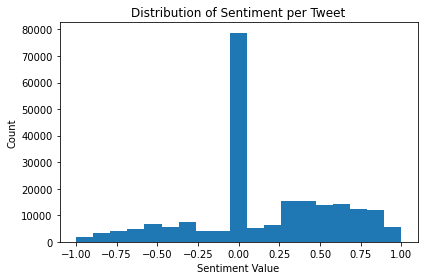

In [11]:
import matplotlib.pyplot as plt
plt.hist(sentiments, bins=np.linspace(-1, 1, 20))
plt.title('Distribution of Sentiment per Tweet')
plt.ylabel('Count')
plt.xlabel('Sentiment Value')
# plt.yscale('log')
plt.tight_layout()
plt.savefig('graphs/sentiments_tweets.jpg')
plt.show()

In [12]:
# Sentiment analysis
pbar = tqdm(total=company_meta.shape[0])

rows_arr = []
out_cols = ['Symbol', 'tweetCount', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount', 'weightedSentiment', 'unweightedSentiment']
try:
    for ipo_date, ticker, company in company_meta[[
        'IPO Date',
        'Symbol',
        'Name',
    ]].values:
        # pbar.set_description(f"Company: {company}")
        out_csv = os.path.join(tweets_dir, str(ticker)+'.csv')

        tweets_df = pd.read_csv(out_csv, index_col=0)

        # get weighted average for sentiment
        weights = tweets_df[['replyCount', 'likeCount', 'retweetCount', 'quoteCount']].sum(axis=1)
        if sum(weights) == 0:
            mean_sentiment = np.mean(tweets_df["sentiment"])
        else:
            mean_sentiment = np.average(tweets_df['sentiment'], weights=weights)

        row_entry = [
            ticker, 
            tweets_df.shape[0],
            np.mean(tweets_df['replyCount']),
            np.mean(tweets_df['retweetCount']),
            np.mean(tweets_df['likeCount']),
            np.mean(tweets_df['quoteCount']),
            mean_sentiment,
            np.mean(tweets_df["sentiment"])
        ]

        rows_arr.append(row_entry)
        pbar.update(1)

except KeyboardInterrupt:
    print('Interrupted')
    pass

final_df = pd.DataFrame(
    rows_arr,
    columns=out_cols
)
final_df.to_csv('./data/company_tweets.csv')

pbar.close()
final_df.head()

100%|██████████| 1050/1050 [00:04<00:00, 248.19it/s]


,Symbol,tweetCount,replyCount,retweetCount,likeCount,quoteCount,weightedSentiment,unweightedSentiment
0,SXTC,8,0.000,0.125000,0.000000,0.000,0.296000,0.037000
1,MTC,1000,0.299,0.570000,2.489000,0.072,0.301166,0.185244
2,MDJH,11,0.000,0.090909,0.090909,0.000,0.000000,0.057818
3,BCOW,6,0.000,0.000000,0.000000,0.000,0.000000,0.000000
4,RBKB,9,0.000,0.000000,0.000000,0.000,0.000000,0.000000


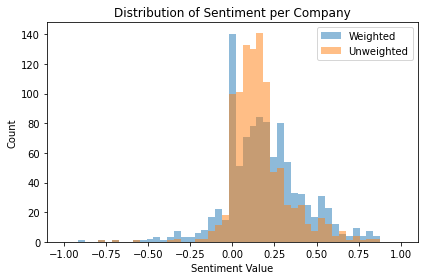

In [13]:
plt.hist(final_df.weightedSentiment, bins=np.linspace(-1, 1, 50),  alpha=0.5, label='Weighted')
plt.hist(final_df.unweightedSentiment, bins=np.linspace(-1, 1, 50),  alpha=0.5, label='Unweighted')
plt.title('Distribution of Sentiment per Company')
plt.ylabel('Count')
plt.xlabel('Sentiment Value')
# plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('graphs/sentiments_company.jpg')
plt.show()

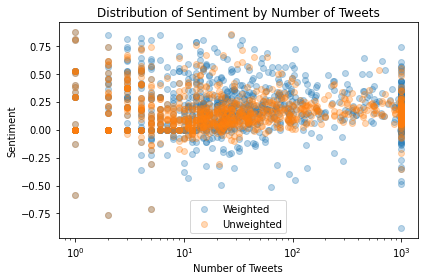

In [14]:
plt.scatter(y='weightedSentiment', x='tweetCount', data=final_df,  alpha=0.3, label='Weighted')
plt.scatter(y='unweightedSentiment', x='tweetCount', data=final_df,  alpha=0.3, label='Unweighted')
plt.title('Distribution of Sentiment by Number of Tweets')
plt.ylabel('Sentiment')
plt.xlabel('Number of Tweets')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('graphs/sentiments_by_numtweets.jpg')
plt.show()